## 1. read 2D point cloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

df = pd.read_csv(r'./data/output_zhang_ascend.csv', encoding='utf-8', header=None, low_memory=False)
data = df.to_numpy()
# only 29 ~ 83 degree
ang_range = data[:, 0].astype(int)
data = data[(ang_range >= 29) == (ang_range <= 83)]
print(data.shape)
print('----------------------')
print(data)

(9714, 2)
----------------------
[[  29.1248  790.    ]
 [  29.2291  790.    ]
 [  29.339   790.    ]
 ...
 [  64.9127    0.    ]
 [  65.0281    0.    ]
 [  65.0885 1603.    ]]


## 2. split all data to each scan 

In [2]:
num_scan = 1 # 1 scan = 360 degree
num_beam = 0 # 1 beam = 0.12 degree
previous_degree = 0 # meaningless
scan_split = [0]

# print('---------- {} time scan ----------'.format(num_scan))
for beam in data:
    # each scan
    # if int(previous_degree) != 0 and int(beam[0]) == 0: 
    if int(previous_degree) - int(beam[0]) > 2: 
        scan_split.append(num_beam)
        num_scan += 1
        # print('---------- {} time scan ----------'.format(num_scan))
    previous_degree = beam[0]

    num_beam += 1

print('scan times:', num_scan)

scan_split.append(data.shape[0])
print('scan_split:', scan_split)

all_data = []
for i in range(len(scan_split)-1):
    all_data.append(data[scan_split[i] : scan_split[i+1]])

scan times: 30
scan_split: [0, 324, 647, 970, 1294, 1617, 1943, 2267, 2590, 2913, 3237, 3562, 3887, 4212, 4536, 4859, 5183, 5506, 5830, 6155, 6479, 6802, 7125, 7448, 7772, 8094, 8417, 8743, 9067, 9390, 9714]


## 3. traverse each scan (real time)

* 3.1 angle range decision
    * ![image](./figs/angle_min_max.jpg)
* 3.2 (ascend) step detection
    * 3.2.1 denoise/smooth
        * SMA (Simple Moving Average): Y = (Yt + Yt-1 + Yt-2 + Yt-3 + Yt-4)/5 （pandas: dataframe.rolling(n).mean()）
        * WMA (Weighted Moving Average): Y = (5Yt + 4Yt-1 + 3Yt-2 + 2Yt-3 + 1Yt-4) /(5+4+3+2+1) （custom function）
        * EMA (Exponential Moving Average): 与WMA算法相似, 但多了一个平滑系a＝2/(n+1) （custom function）
        * MF (Median Filter): 与SMA算法相似只不过变成了中位数, (scipy.signal.medfilt(dataframe, n))
        * SGF (Savitzky-Golay Filter): 是一种多项式最小二乘法拟合的滤波法, 特点是平降噪同时保持原信号形状和宽度不变, 
        ![image](./figs/SG_Filter.jpg)
    * 3.2.2 find inflection point
        * SMA
        * gradient threshold
    * 3.2.3 calculation of step height & step distance
        * ![image](./figs/ascend.jpg)
* 3.3 (descend) step detection
    * 3.3.1 find break point
        * different threshold
    * 3.3.2 calculation of step height & step distance
        * ![image](./figs/descend.jpg)

#### 3.1

In [3]:
# given
h = 665
d_min = 300
d_max = 6000

# calculate
min_theta = np.arctan(d_min/h)
min_theta = min_theta*180/np.pi

max_theta = np.arctan(d_max/h)
max_theta = max_theta*180/np.pi

print('min angle:', int(min_theta))
print('max angle:', int(max_theta))

min angle: 24
max angle: 83


#### 3.2.1

In [4]:
def wma(y):
    weights = np.arange(len(y)) + 1
    wma = np.sum(weights * y) / weights.sum()

    return wma

def ema(y, n):
    ema = np.zeros(len(y))
    ema[:] = np.nan # initial via NAN
    ema[n-1] = y[:n].mean() # only calculate the head part via SMA
    for i in range(n, len(y)):
        ema[i] = ema[i-1] + (y[i] - ema[i-1]) / (n + 1) * 2

    return ema

#### 3.2.3

In [5]:
# given
h = 675
d = 1103
theta = 59.6997
theta = theta*np.pi/180

# calculate
h1 = d * np.cos(theta)
h2 = h - h1
d1 = d * np.sin(theta)
d2 = d1

print('step height:', int(h2))
print('step distance:', int(d2))

step height: 118
step distance: 952


#### 3.3.2

In [6]:
# given
h = 710
d = 2118
theta = 68.9
theta = theta*np.pi/180

# calculate
h3 = d * np.cos(theta)
h4 = h3 - h
d3 = h * np.tan(theta)
d4 = d3

print('step height:', int(-h4))
print('step distance:', int(d3))

step height: -52
step distance: 1840


### code of 3

========== 1 time scan ==========
all data: 324
error data: 4


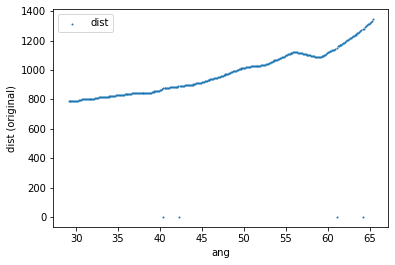


----------Descend----------
~~~ NO DITCH AHEAD ~~~

----------Ascend----------


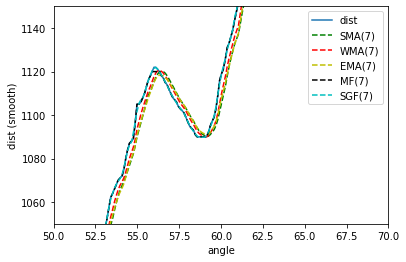

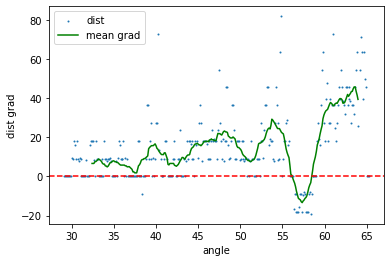

!!! STEP FOUND AHEAD !!!
Angle:59.6997, Distance:1103.0
Step Height: 118, Step Distance: 952


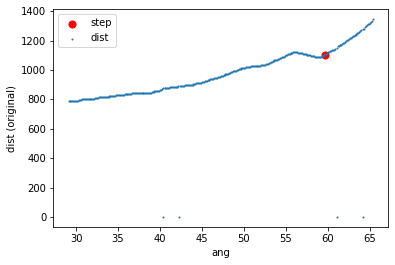

In [8]:
# common
h = 675
if_visual = True
# ascend
window_size = 7
k = 3 # k-th order polynomial of SGF (should less than window_size)
gradient_window_size = 20 # number of continuous distance gradients (to find inflection point) (!!must be even!!)
gradient_threshold = 0 # decide gradient boundary (to find inflection point)
# descend
diffence_threshold = 75


for id_scan, scan_data in enumerate(all_data):
    print('========== {} time scan =========='.format(id_scan+1))
    print('all data: {}'.format(len(scan_data)))


    ##### number of error data #####
    num_error = 0
    for beam_data in scan_data:
        if beam_data[1] == 0:
            num_error += 1
    print('error data: {}'.format(num_error))
    
    if if_visual:
        ##### original scan data #####
        # plt.xlim((50, 55)) # degree
        # plt.ylim((1300, 1900)) # distance
        plt.scatter(scan_data[:, 0], scan_data[:, 1], s=1, label='dist')
        plt.xlabel('ang')
        plt.ylabel('dist (original)')
        plt.legend()
        plt.show()

    ##### non-error scan data #####
    data = scan_data[scan_data[:, 1]!=0]


    print()
    print('----------Descend----------')


    #################### descend ####################

    ########## 1. find break point ##########
    diffs = []
    for i in range(len(data)-1):
        diffs.append([ data[i][0], data[i+1][1] - data[i][1]]) # subtraction
    diffs = np.array(diffs)

    if False:
        plt.scatter(diffs[:, 0], diffs[:, 1], s=1, label='dist diff') # differences
        plt.axhline(y=75, color='r', linestyle='--')
        plt.xlabel('angle')
        plt.ylabel('dist diffs')
        plt.legend()
        plt.show()

    break_point = []
    for i, (ang, dist_diff) in enumerate(diffs):
        if dist_diff > diffence_threshold:
            # angle, distance, distance gradient
            break_point.append([ data[i+1][0], data[i+1][1], dist_diff ]) ##### break point (s)
    
    if len(break_point) == 0:
        print('~~~ NO DITCH AHEAD ~~~')
    else:
        ##### only use the first break point #####
        bre_ang, bre_dist, bre_dist_diff = break_point[0]
        print('!!! DITCH FOUND AHEAD !!!')
        print('Angle:{}, Distance:{}'.format(bre_ang, bre_dist)) ########## !!! final break point !!! ##########


        ########## 2. calculate step height(h2) & step distance(d2) ##########
        ##### calculate h2 & d2 #####
        # given
        d = bre_dist
        theta = bre_ang
        theta = theta * np.pi / 180
        # calculate
        h3 = d * np.cos(theta)
        h4 = h3 - h
        d3 = h * np.tan(theta)
        d4 = d3
        print('Ditch Height: {}, Ditch Distance: {}'.format(int(-h4), int(d3)))

        if False:
            ##### original scan data #####
            plt.scatter(bre_ang, bre_dist, s=50, c='y', label='ditch') # break point
            plt.scatter(scan_data[:, 0], scan_data[:, 1], s=1, label='dist')
            plt.xlabel('ang')
            plt.ylabel('dist (original)')
            # plt.xlim((0, 90))
            # plt.ylim((0, 5000))
            plt.legend()
            plt.show()


    print()
    print('----------Ascend----------')


    #################### ascend ####################

    ########## 1. denoise/smooth ##########
    # original (non-error)
    df = pd.DataFrame(data = data, columns=['ang', 'dist'])
    # SMA
    df['SMA({})'.format(window_size)] = df['dist'].rolling(window_size).mean().round(2)
    # WMA
    df['WMA({})'.format(window_size)] = df['dist'].rolling(window_size).apply(wma, raw=True).round(2)
    # EMA
    df['EMA({})'.format(window_size)] = ema(df['dist'], window_size).round(2) 
    # MF
    df['MF({})'.format(window_size)] = signal.medfilt(df['dist'], window_size).round(2) 
    # SGF
    df['SGF({})'.format(window_size)] = signal.savgol_filter(df['dist'], window_size, k, mode='nearest') 

    if True:
        plt.plot(df['ang'], df['dist'], label='dist') # original (non-error)
        plt.plot(df['ang'], df['SMA({})'.format(window_size)], 'g--', label='SMA({})'.format(window_size)) # SMA
        plt.plot(df['ang'], df['WMA({})'.format(window_size)], 'r--', label='WMA({})'.format(window_size)) # WMA
        plt.plot(df['ang'], df['EMA({})'.format(window_size)], 'y--', label='EMA({})'.format(window_size)) # EMA
        plt.plot(df['ang'], df['MF({})'.format(window_size)], 'k--', label='MF({})'.format(window_size)) # MF
        plt.plot(df['ang'], df['SGF({})'.format(window_size)], 'c--', label='SGF({})'.format(window_size)) # SGF
        # plt.axvline(x=56, color='r', linestyle='--')
        # plt.axvline(x=59.3, color='r', linestyle='--')
        plt.xlim((50, 70))
        plt.ylim((1050, 1150))
        plt.xlabel('angle')
        plt.ylabel('dist (smooth)')
        plt.legend()
        plt.show()


    ########## !!! use/not use smoothing !!! ##########
    # SMA
    # data = np.hstack((df['ang'].to_numpy()[:, np.newaxis], df['SMA({})'.format(window_size)].to_numpy()[:, np.newaxis]))
    # WMA
    # data = np.hstack((df['ang'].to_numpy()[:, np.newaxis], df['WMA({})'.format(window_size)].to_numpy()[:, np.newaxis]))
    # EMA
    # data = np.hstack((df['ang'].to_numpy()[:, np.newaxis], df['EMA({})'.format(window_size)].to_numpy()[:, np.newaxis]))
    # MF
    data = np.hstack((df['ang'].to_numpy()[:, np.newaxis], df['MF({})'.format(window_size)].to_numpy()[:, np.newaxis])) # best for skewness
    # SGF
    # data = np.hstack((df['ang'].to_numpy()[:, np.newaxis], df['SGF({})'.format(window_size)].to_numpy()[:, np.newaxis]))


    ########## 2. find inflection point ##########
    ##### get gradient #####
    diffs = []
    for i in range(len(data)-1):
        diffs.append([ data[i][0], (data[i+1][1] - data[i][1]) / (data[i+1][0] - data[i][0]) ]) # gradient

    diffs = np.array(diffs)

    ##### decision via mean gradient #####
    mean_i1_2_i10 = []
    mean_i10_2_i20 = []

    inflection_points = []

    for i, (ang, dist_diffs) in enumerate(diffs):
        if (i+2*gradient_window_size) > len(diffs): # prevent moving window overflow
            break

        i1_2_i10 = diffs[i : i+gradient_window_size][:, 1]
        i10_2_i20 = diffs[i+gradient_window_size : i+2*gradient_window_size][:, 1]
        
        mean_i1_2_i10.append(i1_2_i10.mean())
        mean_i10_2_i20.append(i10_2_i20.mean())
        if i1_2_i10.mean() < gradient_threshold and i10_2_i20.mean() > gradient_threshold:
            # angle, distance, distance gradient
            index = int(i+gradient_window_size)
            inflection_points.append([  data[index][0], data[index][1], diffs[index][1]  ]) ##### inflection point(s)

    if if_visual:
        plt.scatter(diffs[:, 0], diffs[:, 1], s=1, label='dist') # gradient
        mean_i10_2_i20_start = int(gradient_window_size*1.5 - 1)
        mean_i10_2_i20_end = int(-(gradient_window_size/2))
        # plt.axvline(x=56, color='r', linestyle='--')
        # plt.axvline(x=59.3, color='r', linestyle='--')
        plt.plot(diffs[:, 0][mean_i10_2_i20_start:mean_i10_2_i20_end], mean_i10_2_i20, 'g-', label='mean grad') # mean of 10-20 gradients window
        # plt.xlim((0, 90))
        # plt.ylim((-150, 150)) 
        plt.xlabel('angle')
        plt.ylabel('dist grad')
        plt.legend()
        plt.axhline(y=0, color='r', linestyle='--')
        plt.show()

    if len(inflection_points) == 0:
        print('~~~ NO STEP AHEAD ~~~')
    else:
        ##### only use the last inflection point #####
        infle_ang, infle_dist, infle_dist_diff = inflection_points[-1]
        print('!!! STEP FOUND AHEAD !!!')
        print('Angle:{}, Distance:{}'.format(infle_ang, infle_dist)) ########## !!! final inflection point !!! ##########

 
        ########## 3. calculate step height (h2) & step distance (d2) ##########
        ##### given #####
        d = infle_dist
        theta = infle_ang
        theta = theta * np.pi / 180
        ##### calculate h2 & d2 #####
        h1 = d * np.cos(theta)
        h2 = h - h1
        d1 = d * np.sin(theta)
        d2 = d1
        print('Step Height: {}, Step Distance: {}'.format(int(h2), int(d2)))

        if True:
            ##### original scan data #####
            # plt.xlim((50, 70)) # degree
            # plt.ylim((600, 1200)) # distance
            if len(inflection_points) != 0:
                plt.scatter(infle_ang, infle_dist, s=50, c='r', label='step') # inflection point

            plt.scatter(scan_data[:, 0], scan_data[:, 1], s=1, label='dist')
            plt.xlabel('ang')
            plt.ylabel('dist (original)')
            plt.legend()
            plt.show()


    print()
    print()
    print()

    break

#### (descend) calculation sample of step height & step distance 

In [11]:
height = 710 # mm
width = 3000
step = 75
diff_degree = 1 # sampling

##### on the step
C = np.sqrt(height**2 + width**2)
print('short hypotenuse: {:.2f}'.format(C))

radian = np.arctan(height/width)
degree = radian * 180/np.pi
print('degree: {:.2f}'.format(degree))


##### under the step
long_height = height + step
long_C = long_height/np.sin(radian)
print('long hypotenuse: {:.2f}'.format(long_C))

# difference
diff = long_C - C 
print('difference (long & original): {:.2f}'.format(diff))


##### on the step (before step boundary)
small_degree = degree + diff_degree
print('small degree: {:.2f}'.format(small_degree))

small_radian = small_degree * np.pi/180
short_C = height / np.sin(small_radian)

# difference
diff2 = C - short_C
print('difference (original & short): {:.2f}'.format(diff2))

short hypotenuse: 3082.87
degree: 13.32
long hypotenuse: 3408.53
difference (long & original): 325.66
small degree: 14.32
difference (original & short): 211.32
